<h1><center>Machine Learning</center></h1>


<h2><center> Airbnb Data Analysis and Price Prediction Quarters Q2-Q4 2022 </center> </h2>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import subprocess
# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
%%capture
!pip install pandas

In [ ]:
%%capture
!pip install scikit-learn

In [ ]:
%%capture
!pip install scipy

In [ ]:
%%capture
!pip install shap

In [ ]:
%%capture
!pip install joblib

In [ ]:
%%capture
!pip install geopandas
!pip3 install contextily

In [ ]:
%%capture
!pip install missingno

In [ ]:
%%capture
!pip install xgboost

In [ ]:
%%capture
!pip install lightgbm

In [ ]:
%%capture
!pip install ydata-profiling

In [ ]:
# %%capture
# !pip install --upgrade dpcpp_cpp_rt

In [ ]:
%%capture
!pip install scikit-learn-intelex
!pip install fasttreeshap

In [ ]:
%%capture
!pip install torch

In [ ]:
#  change directory
%cd '/content/drive/MyDrive/airbnb'

## 1. Introduction

__Airbnb__, Inc. is an American San Francisco-based company operating an online marketplace for short-term homestays and experiences. The company acts as a broker and charges a commission from each booking.  The company not only have revolutionized the tourism industry but have also facilitated an unaffordable increase in home rents due to a lack of regulation (https://en.wikipedia.org/wiki/Airbnb).

With this in mind, the objectives of this project are:

* Visualise the properties offered in the 20 Arrondissements of Paris during Quarters Q2 - Q4 of 2022
* Select features that impact the price of a listing
* Identify potential inactive listing with outlier prices - noise
* Identify the most expensive and cheapest neighbourhoods
* Identify the type of accommodations and properties more often offered by Airbnb
* Identify listings that offered for long-term stays
* Find the model that best predicts the listing prices
* Compute Shapley number for the feature of the best model explainability (XAI)


Airbnb datasets Q2-Q4 2022 can be sourced from  http://insideairbnb.com/get-the-data/

The tasks below will be undertaken in this version:

- Drop highly __correlated reviews__
- The average of the __highly correlated reviews__ scores will be added as a new column in the data frame
- Produce a __Profile Report__ of the hot-encoded and scaled data using pandas __profiler__.
  Note: uncomment the cell to run the test
- Accelerate Scikit-learn models training by using intel ```scikit-learn-intelex```
- Use the latest __version of XGBoost__ running on __CPU__
- Apply __max-min scaling__ to features and price
- Training will be done on the __training dataset__ and performance tested on the __validation dataset__
- __Statistical comparison__ of the performance of the best top training models using the non-parametric __Kruskal-Wallis__ __H-test__ to test the null hypothesis. In addition, the __Kolmogorov-Smirnov__ test for goodness of fit will be used for pairwise comparison of the top models.
- The __grid search__ optimisation will use the training and validation datasets and the __performance__ of the best model will be measured on the __test subset__.
- The __SHAP__ values will be computed for the best model on the test dataset

### 1.1 Libraries and frameworks

In [ ]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import joblib
import missingno as msno
from pandas.tseries.offsets import DateOffset
from sklearnex import patch_sklearn
patch_sklearn()
# from daal4py.oneapi import sycl_context#
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import make_column_transformer,TransformedTargetRegressor
from sklearn.feature_selection import mutual_info_regression, SelectPercentile, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
# metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
    mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skorch import NeuralNetRegressor

import torch
from torch import nn
import torch.nn.functional as F
torch.manual_seed(123)
torch.cuda.manual_seed(123)
sns.set_style(style='white')
%matplotlib inline


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 2. Dataset

### 2.1 Creating directory for datasets and downlading data

In [ ]:
paris_dir = os.path.join(os.getcwd(), 'datasets', 'paris')
try:
    os.makedirs(paris_dir, exist_ok=False)
except OSError as error:
    print('Directory already exist')

Directory already exist


In [ ]:
# Creat directory to save figures
plots_dir = os.path.join(os.getcwd(), 'figures')
try:
    os.makedirs(plots_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')


Directory already exist


### 2.2 Frequenty function clean data and save plots

In [ ]:
# Drop columns and rows functions
def drop_columns(col_list=None, df=None):

    df.drop(col_list, axis=1, inplace=True)

def drop_rows(indices=None, df=None):
    df.drop(index=indices, inplace=True)


In [ ]:
def save_plot(plot_name, x=None, y=None):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.savefig(os.path.join(plots_dir, f'{plot_name}.jpg'), bbox_inches='tight',
                        format='jpg')
    return plt.close()

### 2.3 Download the data

The dasets for q2, q3 and q4 will be dowloaded an concatenated.

In [ ]:
# Uncomment to download
download = False
if download:
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/data/listings.csv.gz -O 'datasets/paris/listings_q4.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q4.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q4.csv'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/data/listings.csv.gz -O 'datasets/paris/listings_q3.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q3.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q3.csv'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/data/listings.csv.gz -O 'datasets/paris/listings_q2.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q2.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q2.csv'


### 2.4 Load datasets from csv file

In [ ]:
df_q2 = pd.read_csv(os.path.join(paris_dir, 'listings_q2.csv.gz'), compression='gzip')
df_q3 = pd.read_csv(os.path.join(paris_dir, 'listings_q3.csv.gz'), compression='gzip')
df_q4 = pd.read_csv(os.path.join(paris_dir, 'listings_q4.csv.gz'), compression='gzip')

In [ ]:
# Extract the number of features in each quarter
f2 = df_q2.columns
f3 = df_q3.columns
f4 = df_q4.columns

print(f'Are the features in df_q2 equal to the features in df_q3? {len(f2) == len(f3)}')
print(f'Are the features in df_q3 equal to the features in df_q4? {len(f3) == len(f4)}')

In [ ]:
# find the features in df_q3 that are not in df_q2
drop_cols= list()
for f in f3:
    if f not in f2:
        print(f'drop column: "{f}" from df_q3 and df_q4')
        drop_cols.append(f)

In [ ]:
# Drop column source to concatenate the three datsets in one
for c in drop_cols:
    df_q3.drop(c, axis=1, inplace=True)
    df_q4.drop(c, axis=1, inplace=True)

df_paris = pd.concat([df_q2, df_q3, df_q4], ignore_index=True)
print(f'Dataset features: {len(df_paris)}')


In [ ]:
def data_summary(df, plot_dir=plots_dir, name=None):
    """
    Function to summarise features and properties with missing features
    """

    # find unique listings by id
    properties = len(df.id.unique())

    # find the number of features with nan values per accommodation
    nan_per_accomodation = df.isna().sum(axis=1)

    # Uniquenumber of features missing
    missing_features = np.unique(nan_per_accomodation)

    print(f'Accomodations: {len(df)} | Unique accomodations: {properties}')
    print(f'Dataset features including id: {len(df.columns)} | \
    Accomodations missing features: {len(nan_per_accomodation)}')

    # Visualise the distribution of properties per missing features
    if 0 in nan_per_accomodation.value_counts().keys():
         nan_per_accomodation.value_counts()[1:].plot.bar(color='green', fontsize=10, figsize=(5,3))

    else:
        nan_per_accomodation.value_counts().plot.bar(color='green', fontsize=10, figsize=(5,3))
    plt.title('Missing features in accommodation)
    plt.ylabel('listings count')
    plt.xlabel('missing features')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'{name}.jpg'), bbox_inches='tight',
                    format='jpg')
    plt.close()

    return nan_per_accomodation, missing_features


In [ ]:
print('======== Summary before data cleaning, wrangling and data engineering ========')
missing_features, unique_misses = data_summary(df_paris, name='init-hist')


 <img align="left" src='figures/init-hist.jpg' width=500/>

In [ ]:
df_paris.info()

**Plot here**

<img src='figures/init-hist.jpg' width='400'/>

- Unique Accommodations 73122 in Q2-Q4
- All accomodations 173208
- All listing have at least one feture missing.
- Most of the listing miss 20 or less features,


## 3. Visualisation of listings spread in Paris

In [ ]:
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster
import contextily as cx

- Only visualise the unique properties advertise in Q2-Q4 2022
- Use geopandas, folium and context geo tiles (contextily) to read  and visualise the geolocation of each neighbourhood
- plot the propertieslocation

### 3.1 Interactive localisation - GIS

In [ ]:
property_gis = df_paris.copy()[['id', 'neighbourhood_cleansed','latitude', 'longitude',
                      'price']]
property_gis.drop_duplicates(subset='id', inplace=True)
gis = gpd.read_file(os.path.join(paris_dir, 'neighbourhoods_q4.geojson'))

In [ ]:
acc_coords = property_gis[['latitude', 'longitude']].values.tolist()
coord_size = len(acc_coords)

In [ ]:
paris_coor = [48.85341, 2.3488]
paris_map = folium.Map(location=paris_coor, tiles='openstreetmap',
                       zoom_start=11)

for i, geo in enumerate(gis.geometry.values):
    geo_j = folium.GeoJson(data=geo,
                       style_function=lambda x:{'fillColor': 'blue'})
    folium.Popup(gis.neighbourhood[i]).add_to(geo_j)
    geo_j.add_to(paris_map)
FastMarkerCluster(acc_coords, radius=0.5).add_to(paris_map)
paris_map.save(os.path.join(plots_dir, 'geomap.html'))


In [ ]:
paris_map

### 3.2  Mercador location coordinates  of  the listings and neighboourhoods

In [ ]:
def listings_gis(df, col_name='neighbourhood', title=None, plot_name=None, coordinates=None):

    gdf = gpd.GeoDataFrame(df, crs=4326, geometry=gpd.points_from_xy(df.longitude,
                                                df.latitude))
    # Convert coordinates to Mercador coordinates
    neigh=coordinates.to_crs(epsg=3857)
    listings=gdf.to_crs(epsg=3857)
    ax=neigh.plot(column=col_name, alpha=0.7, legend=True,
                cmap='tab20', figsize=(20, 20), edgecolor='black')
    listings.plot(ax=ax, alpha=0.2, color='blue', marker='o', markersize=2,
                          figsize=(20, 20), legend=False)
    cx.add_basemap(ax)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.savefig(os.path.join(plots_dir, f'{plot_name}.jpg'), bbox_inches='tight',
                        format='jpg')
    plt.close()


In [ ]:
title = 'Listing distribution in Paris Neighbourhoods'
gis_name = 'paris_listings'
listings_gis(property_gis, col_name='neighbourhood', title=title, plot_name=gis_name,
             coordinates=gis)

In [ ]:
(property_gis.neighbourhood_cleansed.value_counts()/len(property_gis)).plot.bar(color='green', fontsize=8,
                                                            figsize=(5, 3))
plt.grid()
save_plot('neighbourhood_listings', x='neighbourhood_cleansed', y='listings density')

**To see the map and bar chart uncomment the markdown code in this cell**
<img align="left" src='figures/paris_listings.jpg' width=500/><img align="right" src='figures/neighbourhood_listings.jpg' width=350/>



## 4. Features exploration data analysis

### 4.1 Summary of features

In [ ]:
# Convert strings to dates
date_time_cols = ['host_since', 'first_review', 'last_review', 'last_scraped',
                  'calendar_last_scraped']
df_paris[date_time_cols] = df_paris[date_time_cols].apply(pd.to_datetime)

In [ ]:
# Types of data in the dataset
df_paris.dtypes.value_counts()

In [ ]:
# Visualize the number of missing data from each feature
msno.bar(df_paris)
name = 'msno_featureschart'
plt.savefig(os.path.join(plots_dir, f'{name}.png'), bbox_inches='tight',
                    format='png')

In [ ]:
# Missing features
df_paris.isnull().mean(axis=0).sort_values(ascending=False).head(10)

### 4.1.1 Drop features with insuficient information

In [ ]:
# Drop features with missiing infor mation for 35% of the listings
cols_to_drop = df_paris.columns[df_paris.isnull().mean(axis=0)> 0.35]
df_paris.drop(cols_to_drop, axis=1, inplace=True)

### 4.2 Features with missing data

In [ ]:
missing_features, unique_misses = data_summary(df_paris, name='col-drop-hist')

**Add histo**
From the histogram of missing features we can observe that most of the accomondations have 12 or less missing features. We will use this number to filter the data and remove the instances with more than 12 missin features. Then we will further proceed to the data engineering and feature selection and dimessionality reduction.

In [ ]:
#  Find the accommodation with more than 12 missing features
print(f'Accomodations with more than 12 missing features: {len(df_paris[missing_features > 12].index)}')

In [ ]:
# Use the threshold to drop accomodations with more than 12 Nan columns (features)
threshold = len(df_paris.columns) - 12
df_paris.dropna(thresh=threshold, inplace=True)

### 4.3 Removing features

---
*   Remove host information from the dataset
*   Remove _minimum_maximum_nights_, _maximum_maximum_nights_, _minimum_minimum_nights_ _maximum_minimum_nights_, _minimum_nights_avg_ntm_', '_maximum_nights_avg_ntm_'
*   maximum and minimun nights will be used for the visualisation and analytics

---

- Neighbourhoods with most hosts **Buttes-Montmartre**, **Popincour**, **Passy**
- Neighbouhoods with smallest number of hosts **Louvre**, **Palais-Bourbon**, **Luxembourg** and **Élysée**.

In [ ]:
# Remove columns
host_col = ['host_id', 'host_name', 'host_location', 'calendar_last_scraped', 'host_url',
            'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
            'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
df_paris.drop(host_col, axis=1, inplace=True)

## 5. Data Cleaning & Wrangling

### 5.1 Non-categorical features

In [ ]:
from pandas.tseries.offsets import DateOffset

In [ ]:
# Find the nan non-categorical features in the dataset
df_paris[df_paris.columns[df_paris.dtypes != 'object']].isna().sum(axis=0)

#### 5.1.2 Drop Features
## **Tasks**

---

Remove information cover under has_availability  maximum_ninghts and minimum_nights

**Availability**

- availability_30                                     
- availability_60                                     
- availability_90                                     
- availability_365

**Counts**

- host_listings_count                                
- host_total_listings_count
- calculated_host_listings_count                      
- calculated_host_listings_count_entire_homes         
- calculated_host_listings_count_private_rooms        
- calculated_host_listings_count_shared_rooms

**scrap_id**
- convert scrap_id to string for filtering pourpose

---



In [ ]:
# Drop instances without host_since information
df_paris.drop(df_paris.host_since[df_paris.host_since.isna()].index, inplace=True)


In [ ]:
# Drop availability columns
drop_avail = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
drop_columns(drop_avail, df_paris)

# Drop counts
drop_counts = ['host_listings_count', 'host_total_listings_count',
               'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
               'calculated_host_listings_count_private_rooms',
               'calculated_host_listings_count_shared_rooms']
drop_columns(drop_counts, df_paris)


In [ ]:
# remap the scrape_id to string for filtration
scrape_id = {sc: f'quarter_{i+2}' for i, sc in enumerate(df_paris.scrape_id.unique())}
df_paris['scrape_id'] = df_paris['scrape_id'].map(scrape_id)

### 5.2 Filter active properties  by reviews

### **Tasks**

---

**Reviews**

- first_review is nan and hosted  6 monts before the Q2 2022 scrape date                                  
- last_review a year before the Q2 2022 scrape date                                                                       

---

In [ ]:
# Get the earliest scrape date and substract 6 months
q2_scraped = (df_paris.last_scraped.nsmallest(1) - DateOffset(months=6)).values[0]
# Remove properties with no reviews and host_sice 6 months before the scrapped date Q2-2022
q2_index = df_paris[(df_paris.first_review.isna()) & (df_paris.host_since < q2_scraped)].index
drop_rows(q2_index, df_paris)

In [ ]:
# Drop properties last reviewed a year before the scrapped date of Q2-2022
q2_last_review = (df_paris.last_scraped.nsmallest(1) - DateOffset(months=12)).values[0]
last_rev_index = df_paris[(df_paris.last_review < q2_last_review)].index
drop_rows(last_rev_index, df_paris)

### 5.3 Categorical features

In [ ]:
df_paris[df_paris.columns[df_paris.dtypes == 'object']].isna().sum(axis=0)


## **Tasks**

---
Remove name and description of the listing - for more complex task NLP can beused to process the content extract information and/or sentiment. We would utilise the amenities to extract the listing features

**Listing description**
*   name
*   description

Remove information about the host except identity_verified

**host information**

*   listing_url
*   picture_url
*   host_thumbnail_url
*   host_picture_url
*   host_verifications - cover in under identity_verified
*   host_has_profile_pic

**identity_verify**

* Drop listings withouth identity verified and last reviewed 6 months before scrapped Q2 2022

**bathrooms_text**

* Drop properties with Nan bathrooms

Reprocess columns content

**Convert text to float**

* bathrooms_text
* price

**Hot encode**

- bathrooms - extract whether is shared or not
- amenities

---



#### 5.3.1 Drop information about the host and the listing name and description

In [ ]:
# Drop name and description and host information
description = ['name', 'description']
drop_columns(description, df_paris)

# Drop name and description and host information
host_info = ['listing_url', 'picture_url', 'host_thumbnail_url', 'host_picture_url',
                    'host_has_profile_pic', 'host_verifications']
drop_columns(host_info, df_paris)

# Drop listings without bathrooms
bathrooms_idx =df_paris[df_paris.bathrooms_text.isna()].index
drop_rows(bathrooms_idx, df_paris)


In [ ]:
# Drop listings withouth identity verified and last reviewed 6 month before scrapped Q2 2022
identity_idx = df_paris[(df_paris.host_identity_verified =='f') &
                        (df_paris.last_review < q2_scraped)].index
drop_rows(identity_idx, df_paris)

#### 5.3.2 Convert categorical to numerical


**Bathrooms**



In [ ]:
df_paris.bathrooms_text.unique()

In [ ]:
def clean_bathroom(string):

    string = string.lower().split(' ')
    if '0' in string:
        string = 1
    elif 'half-bath' in string:
        string = 1
    else:
        string = float(string[0])

    return string

In [ ]:
def encoded_bathrooms(df, col_1=None, col_2=None):
    """
    :param df: dataframe
    :param col_1: column with the text to process
    :param col_2: new clean column
    :return: None
    """
    shared_bathroom = 'shared_bathroom'
    private_bathroom = 'private_bathroom'
    df[col_2] = df[col_1].apply(clean_bathroom)

    d = {shared_bathroom: np.zeros(len(df)),
         private_bathroom: np.zeros(len(df))}

    for i, text in enumerate(df[col_1].values):

        if 'shared' in text:
            d[shared_bathroom][i] = df.iloc[i][col_2]
        else:
            d[private_bathroom][i] = df.iloc[i][col_2]

    df[shared_bathroom] = d[shared_bathroom]
    df[private_bathroom] = d[private_bathroom]

    # Drop bathrooms and bathrooms_text
    drop_columns([col_1, col_2], df)

In [ ]:
encoded_bathrooms(df_paris, col_1='bathrooms_text', col_2='bathrooms' )

**Price**

In [ ]:
from tqdm import tqdm

In [ ]:
def price_to_float(string):
    price = string.split('$')[1].replace(',','')
    return float(price)

In [ ]:
df_paris['price'] = df_paris['price'].apply(price_to_float)

### 5.4 Clean and encode amenities

#### Amenities


### Recommended Essential amenities

https://www.airbnb.co.uk/hospitality#essential-amenities

- Toilet paper
- Soap
- Linens/sheets
- At least one towel per booked guest
- At least one pillow per booked guest


Additional amenities categories include:

https://www.airbnb.co.uk/help/article/586
https://www.airbnb.co.uk/help/article/479


- Bathroom
- Bedroom and laundry
- Entertainment
- Family
- Heating and cooling
- Home Safety
- Internet and office
- Kitchen and dining
- Location features
- Outdoor
- Parking and facilities
- Services
- TV
- free parking.


In [ ]:
# Find accommoodations with empty amenities "[]" and drop them from the dataset
empty_amenities = df_paris[df_paris["amenities"] == "[]"].index
print(f'Accommodations with empty amenities: {len(empty_amenities)}')
drop_rows(empty_amenities, df_paris)

#### 5.4.1 Build functions to process amenities

In [ ]:
# import unidecode
import pickle
from amenities import decode_unicode, common_amenities, preprocess_amenities

In [ ]:
clean_amenities = []
for amenities in df_paris.amenities.values:
    decoded_amenities=decode_unicode(amenities)
    clean_amenities.append(decoded_amenities)

In [ ]:
def unique_amenities(amenities_list):
    for i, l in tqdm(enumerate(amenities_list)):
        if '' in  l:
            amenities_list[i].remove('')
        amenities_list[i] = list(set(amenities_list[i]))
    return amenities_list


In [ ]:
clean_amenities = preprocess_amenities(clean_amenities)
clean_amenities = unique_amenities(clean_amenities)

In [ ]:
df_amenities = common_amenities(clean_amenities)

In [ ]:
print(f'Common amenities: {len(df_amenities)}')

In [ ]:
print("Top 10 amenities")
df_amenities.head(10)

In [ ]:
# Plot the density of the amenities vs frequency
(df_amenities.frequency.value_counts()[0:30]/len(df_amenities)).plot.bar(color='green',
                                                                         fontsize=8, figsize=(6,3))
plt.grid()
plt.ylabel('density')
plt.xlabel('frequency')
plt.show()


In [ ]:
print(f'There are {df_amenities.value_counts()[0:3].sum()} amenities that appear in 3 \
or less listings')



---


- 25 % of the amenities have a frequency of 3 or less
- 50% of the amenities only appear in 76  or less intances


---




In [ ]:
# Drop amenities with <= 3 appearance in the df_amenities
amenities_idx = df_amenities[df_amenities.frequency <= 3].index
drop_rows(amenities_idx, df_amenities)

In [ ]:
for am in df_amenities.index:
    if 'years old'in am:
        drop_rows(am, df_amenities)

In [ ]:
# Remove from amenities toilettries brands
toiletries = ['garnier', 'sanex', 'dove', 'dop', 'uriage', 'savon de marseille']
for item in toiletries:
    if item in df_amenities.index:
        drop_rows(item, df_amenities)

In [ ]:
# Create a dataframe with encoded amenities
amenties_array = np.zeros((len(clean_amenities), len(df_amenities)))
encoded_amenities = pd.DataFrame(data=amenties_array, columns=df_amenities.index)

In [ ]:
# Hot-encoding the encoded_amenities dataframe
for i in tqdm(range(len(clean_amenities))):
    for amenity in df_amenities.index:
        if amenity in clean_amenities[i]:
            encoded_amenities.at[i, amenity] = 1


In [ ]:
# Drop the amenities column from df_paris and reset index
drop_columns('amenities', df_paris)
df_paris.reset_index(drop=True, inplace=True)

In [ ]:
# Drop duplicated free weights with fitness
encoded_amenities[['free weights', 'gym or fitness equipment']][encoded_amenities['free weights']==1]
# drop_columns('free weights', encoded_amenities)


In [ ]:
drop_columns('free weights', encoded_amenities)

## Add  code for coffe and stream services here

In [ ]:
def regroup_amenities(df, cols_to_group=None, grouped_col=None):

    regroup = np.zeros(len(df))

    for i, v in enumerate(df[cols_to_group].values):
        if v.any() == 1:
            regroup[i] = 1

    drop_columns(col_list=cols_to_group, df=df)

    df[grouped_col] = regroup


In [ ]:
# Find coffee machine or coffee makers in the dataset
coffee_cols = [col for col in encoded_amenities.columns if 'coffe'in col or 'espresso' in col]
encoded_amenities[coffee_cols].sum(axis=0)

In [ ]:
encoded_amenities[coffee_cols].values.shape

In [ ]:
streaming_cols = ['amazon prime video', 'hbo max', 'fire tv', 'hulu', 'roku']
encoded_amenities[streaming_cols].sum(axis=0)

In [ ]:
encoded_amenities[['amazon prime video', 'hbo max', 'fire tv', 'hulu', 'roku']].sum(axis=0).plot.bar(
    figsize=(3,3), color='green')
plt.grid()
plt.xlabel('streaming service')
plt.ylabel('listings count')
plt.show()

In [ ]:
# Regroup coffee makers
regroup_amenities(encoded_amenities, cols_to_group=coffee_cols, grouped_col='coffee_maker')

# Regroup straming services
regroup_amenities(encoded_amenities, cols_to_group=streaming_cols,
                  grouped_col='stream_service')

In [ ]:
encoded_amenities[['cable', 'stream_service']].value_counts()

In [ ]:
df_paris[['stream_service', 'cable']][(df_paris.stream_service==1) |
            (df_paris.cable ==1)].value_counts().plot.bar(color='green', figsize=(3,3))
plt.grid()
plt.xlabel('streaming services')
plt.xticks([0, 1, 2],['cable', 'stream_service', 'streaming and cable'])
plt.ylabel('number of listing')
plt.show()

###  **5.5 Wrangling propery_type and room_type**

In [ ]:
print(f'Unique types of property in airbnb: {len(df_paris.property_type.unique())}')

print('Examples of property_type include in the dataset')
df_paris.property_type.unique()[0:20]



*   **property_type** may contain information about the **room_type** i.e Room in hotel, hotel; Private room in loft
*   The propety_type will be extracted from the string



In [ ]:
def clean_property(st):
    st = st.lower()
    if 'dome' in st and 'ice' in st:
        st = 'ice dome'
    elif 'farm' in st:
        st = 'farm'
    elif 'nature lodge' in st or 'entire place' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'serviced' in st or 'boutique' in st or 'rental' in st or 'casa' in st or 'suite' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'home' in st and not 'in home':
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'bed and breakfast' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-3:]))
    elif 'boat' in st:
        st = 'boat'
    else:
        st = st.split(' ')
        if st[-1] == 'room':
            st = ' '.join(map(str, st[-2:]))
        else:
            st = st[-1]
    return st

In [ ]:
# Process property_type
df_paris['property_type'] = df_paris['property_type'].apply(clean_property)

In [ ]:
print('Properties that offer hotel rooms and are neither hotels or boutique hotels:')
df_paris.property_type[(df_paris.room_type == 'Hotel room')  &
                       (~df_paris.property_type.isin(['hotel', 'boutique hotel']))].unique()

In [ ]:
# Rename private rooms in hotel and in boutique hotel to Hotel rooms and Hotel rooms into Private
# rooms if associated with other accommodations
for i, t in df_paris[['property_type', 'room_type']].iterrows():
    if t[0] == 'aparthotel' and t[1] == 'Hotel room':
        df_paris.at[i, 'room_type'] = 'Private room'
    elif 'hotel' not in t[0] and t[1] == 'Hotel room':
        df_paris.at[i, 'room_type'] = 'Private room'
    elif t[1] == 'Private room' and (t[0] == 'hotel' or  t[0] == 'boutique hotel'):
        df_paris.at[i, 'room_type'] = 'Hotel room'

In [ ]:
(df_paris.room_type.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8, figsize=(4, 3))
plt.xlabel('room_type')
plt.ylabel('density')
plt.grid()

### **5.6. Fill missing data (NaN)**



---
 **Categorical**

*  host_is_superhost

---
**Non_categorical**

*   all reviews
*   beds
*   bedrooms
---


#### **5.6.1 Fill nan - categorical**

In [ ]:
df_paris[df_paris.columns[df_paris.dtypes == 'object']].isna().sum(axis=0)

#### **Superhost**

In [ ]:
# If superhost isna then it will be label with f (false)
df_paris.host_is_superhost.fillna(value='f', inplace=True)

#### **5.6.2 Fill nan numerical features**

In [ ]:
df_paris[df_paris.columns[df_paris.dtypes != 'object']].isna().sum(axis=0)

**Beds and bedrooms**

- Fill nan of bed  and bedrooms with by gropuping data with the same  number of beds or beddrooms and accomodates and computing the median
- If the are not similar accomodations and then follow condition minimum 1 up top  accomodates//3

In [ ]:
def fill_beds_bedrooms(df, filters=None, cols_to_fill=None):
    """
    :param df: data frame
    :param filters: list of columns to filter data
    :param cols_to_fill: columns to fill nan
    :return:
    """

    if cols_to_fill is None:
        cols_to_fill = ['bedrooms', 'beds']
    assert len(filters) == 6, 'the length of filters must be 6'
    assert cols_to_fill == ['bedrooms', 'beds'], "col_to_fill must be ['bedrooms', 'beds']"

    for col in cols_to_fill:

        print('==============================', col, '==============================', sep='\n')
        feat_idx = df[df[col].isna()].index

        for idx in tqdm(feat_idx):
            col_list = df.loc[idx][filters].values

            # Find accommodation with similar features
            if col == 'beds':
                fill_idx = df[(df[filters[0]] != col_list[0]) &
                              (df[filters[1]] == col_list[1]) &
                              (df[filters[2]] == col_list[2]) &
                              (df[filters[3]] == col_list[3]) &
                              (df[filters[4]] == col_list[4]) &
                              (df[filters[5]].notna())].index.values
            else:
                fill_idx = df[(df[filters[0]] != col_list[0]) &
                              (df[filters[1]] == col_list[1]) &
                              (df[filters[2]] == col_list[2]) &
                              (df[filters[3]] == col_list[3]) &
                              (df[filters[4]].notna()) &
                              (df[filters[5]] == col_list[5])].index.values

            # Compute the median
            if fill_idx.size == 0:
                if df.at[idx, filters[3]] <= 3:
                    fill_value = 1
                else:
                    fill_value = df.at[idx, filters[3]]//2
            else:
                fill_value = df.loc[fill_idx][col].median(skipna=True)

            df.at[idx, col] = fill_value


In [ ]:
filtering_features = ['id', 'property_type', 'room_type', 'accommodates',
                    'bedrooms', 'beds']
fill_beds_bedrooms(df_paris, filters=filtering_features)

#### **5.6.3 Reviews Scores**

In [ ]:
review_cols = [ k for k, v in df_paris[df_paris.columns[df_paris.dtypes ==
                                            'float64']].isna().sum(axis=0).items() if v >0]

In [ ]:
# Compute Nan per feature
df_paris[review_cols].isna().sum()

In [ ]:
def fillna_per_col_median(df, col_to_fill=None):

    for col in col_to_fill:
        df[col].fillna(value=df[col].median(), inplace=True)

# Fill missing reviews
fillna_per_col_median(df_paris, review_cols)


In [ ]:
# Replace 0 with the median
df_paris['number_of_reviews'] = [df_paris.number_of_reviews.median() if n==0 else n
                                 for n in df_paris.number_of_reviews.values]

In [ ]:
# Concatenate encoded amenities with df_paris
concat_paris_df = pd.concat([df_paris, encoded_amenities], axis=1)
concat_paris_df.to_pickle('paris_clean_df.pkl')

In [ ]:
del concat_paris_df
del df_paris
del encoded_amenities
gc.collect()

## 6. Price visualisations and filtering



*   Compute percentile and remove the properties with price outside the range p01 > price < p99



In [ ]:
df_paris = pd.read_pickle('paris_clean_df.pkl')
# from here

In [ ]:
df_paris.head()

### 6.1 Price stats

In [ ]:
df_paris.price.describe()

In [ ]:
print(f'There are {len(df_paris[df_paris.price == 1])} accommodation(s) with price $ 1.')
print(f'The type of properties are : {df_paris.property_type[df_paris.price == 1].unique()} \
and room {df_paris.room_type[df_paris.price == 1].unique()}')

In [ ]:
# Find the top k=3 largest prices and drop them from the dataset
print('============== The three largest prices ===========')
print(df_paris.price.nlargest(3))

In [ ]:
# Drop the 3 largest prices and the smallest price from the dataframe
drop_rows(df_paris.price.nlargest(3).index, df_paris)
drop_rows(df_paris[df_paris.price == 1].index, df_paris)

- The minimum price of accomodation is $\$ 1$.  There is 1 listing with $\$ 1$ price.
- Maximum price is $\$ 99140.0$.
- 50 % of the listings have a price of $\$ 120 $ per night and a mean price $ \$ 180.91$.
- 75 % of the accommomodations have a price up to $\$ 200$ per night.
- It is highly certain that the maximum and minimum prices are outliers.

In [ ]:
# Visualise price dstribution
df_paris.price.hist(bins=200, color='green', figsize=(6, 4))
plt.xlabel('price')
plt.ylabel('number of listings')
plt.show()


In [ ]:
# Compute percentile for the price to eliminate potential outliers
df_paris.price.quantile([0.005, 0.01, 0.25, 0.5, 0.75, 0.80, 0.90, 0.95, 0.99, 0.995])

- Percentile **1\%** shows a price <= \$34.0
- **Median** price \$120
- **75\%** of the listing have price <= \$200.0
- Percentile **99\%** shows a price <= \$969.86
- The price distribution is skewed to the right

#### 6.1.1 Remove price outliers with percentile


*   Preserving the accommodations within  %1 and 99% range ensure that unique luxurios accommodationes and shared accommodations are cover in the range.



In [ ]:
# Find listings with price less than q01 and greater than q99
q_01 = df_paris.price.quantile(0.01)
q_99 = df_paris.price.quantile(0.99)
q_indices = df_paris[(df_paris.price < q_01) | (df_paris.price > q_99)].index
# Drop instances
drop_rows(q_indices, df_paris)

In [ ]:
df_paris.price.hist(bins=200, color='green', figsize=(5, 3))
save_plot('price_freq_01_99', x='price', y='frequency')



---



#### 6.1.2 Remove any columns that maybe zero after dropping the quantile

In [ ]:
# Find unique types of the features
df_paris.dtypes.unique()

In [ ]:
def drop_zero_sum_columns(df):
    numeric_cols = df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]
    for col in numeric_cols:
        if df[col].sum() == 0:
            drop_columns(col, df)

drop_zero_sum_columns(df_paris)

### 6.2  Price filter price by minimum_nights stay

In [ ]:
print('Accommodation minimum_nights stats',
      '----------------------------------', sep='\n')
df_paris.minimum_nights.describe()

In [ ]:
# Find the three longest minimum stay
df_paris.drop_duplicates(subset='minimum_nights').minimum_nights.nlargest(3)

In [ ]:
print('Accommodation maximum_nights stats',
      '----------------------------------', sep='\n')
df_paris.maximum_nights.describe()

In [ ]:
# Find the three longest maximum stay
df_paris.drop_duplicates(subset='maximum_nights').maximum_nights.nlargest(3)

We can observe that:
- 50 % of the listings are short-term stays up to 3 days
- 75% of the listings have a **minimum_nights** of up to 4 nights.
- The maximum in the **minimum_nights** is 1000 equivalent to 2.74 years. This is an indication of an outlier.
- Listings are markedly split into short term  $<5$ **minimum_nights** and long term starting from 30 nights.
- Airbnb is taken over the **long-term rentals**

In [ ]:
# Plot bar for minimum_nights counts
(df_paris.minimum_nights.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=10,
                                                                figsize=(15,6))
plt.ylabel('density')
plt.xlabel('minimum_nights')
plt.grid()

In [ ]:
print(f'There are {str(len(df_paris[df_paris.minimum_nights >= 30]))} listings in airbnb \
Paris that required a minimun_nights stay of 30 nights.')
print('--------' * 12)
print(f'The maximum minimun_nights is {df_paris.minimum_nights.max()} \
    ({np.round(df_paris.minimum_nights.max()/365, 2)} years).')
unique_acc = df_paris.id[df_paris.minimum_nights >=30].unique()
unique_id = df_paris.id.unique()
print('--------' * 12)
print(f'Unique properties (id) : {len(unique_id)}')
print('--------' * 12)
print(f'Unique properties (id) with minimum_nights >= 30: {len(unique_acc)}')
print('--------' * 12)
print(f'{round(len(unique_acc)/len(unique_id)*100, 2)}% unique listings from Q2-Q4 2022 -\
required 30 minimum_nights - long term lodging')
print('--------' * 12)


In [ ]:
# Compute the quantiles after removing the ouliers
print('Percentile computation for the minimum_nights')
df_paris.minimum_nights.quantile([0.75, 0.80, 0.90, 0.95, 0.99, 0.995, 0.999])

In [ ]:
# Plot bar for maximum_nights counts
(df_paris.maximum_nights.value_counts()[0:50]/len(df_paris)).plot.bar(color='green', fontsize=10,
                                                                figsize=(15,6))
plt.ylabel('density')
plt.xlabel('maximum_nights')
plt.grid()

In [ ]:
# Compute maximum
print('Percentile computation for the maximum_nights')
df_paris.maximum_nights.quantile([0.17, 0.20, 0.40, 0.50, 0.55, 0.60, 0.90, 0.95])

* 40% of the listings in Q3-Q4 offered maximum stays of 1125
* 19% of the listing from Q3-Q4 offered maximum stay of 365 days



#### 6.2.1 Drop listing with minimum of nights over 365

In [ ]:
long_term = df_paris.minimum_nights[df_paris.minimum_nights > 365].index.values
drop_rows(long_term, df_paris)
print(f' Size of dataframe after dropping of listings with minimum \
nights over 365: {len(df_paris)}')

In [ ]:
# Drop any potential zero sum coolumns after removinglisting with price over the 99 percentile
drop_zero_sum_columns(df_paris)

In [ ]:
min_nights = []
for n in df_paris.minimum_nights.values:
    if  n <= 7:
        min_nights.append('short_term')
    elif  n < 30:
        min_nights.append('medium_term')
    else:
        min_nights.append('long_term')

In [ ]:
# Remap to short_term minimum_nights < 30 and long_term for minimum_nights from 30.
df_paris['minimum_nights'] = min_nights

In [ ]:
# Describe the the count of listings for short, medium and long stays.
df_paris.groupby(['minimum_nights'])['price'].describe().sort_values(by='mean', ascending=False)

In [ ]:
(df_paris.minimum_nights.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8,
                                                                figsize=(4, 4))
plt.grid()
plt.xlabel('Mininum lenght of the stay')
plt.ylabel('density')
plt.show()
save_plot('stay', x='scraped_id', y='density')

In [ ]:
df_paris[['price', 'minimum_nights']].boxplot(by ='minimum_nights', figsize=(4, 3))
plt.title('')
plt.xlabel('minimum_nights')
plt.ylabel('price')
plt.show()
save_plot('min_nighst_box', x='minimum_nights', y='price')

**8.74\%** of the listings in airbnb required long term stays starting from 30 days

### 6.3 Price filter price by scrape_id




In [ ]:
df_paris.groupby(['scrape_id'])['price'].describe().sort_values(by='mean',
                                                        ascending=False)

In [ ]:
# Plot bar listigs per quarter
df_paris.scrape_id.value_counts().plot.bar(color='green', fontsize=8,
                                           figsize=(2, 2), xlabel='year quarter 2022',
                                           ylabel='listings')
plt.grid()
plt.show()
save_plot('quarters_density', x='scraped_id', y='density')

In [ ]:
df_paris[['price', 'scrape_id']].boxplot(by='scrape_id', figsize=(4, 3),
                                         xlabel=' year quarters 2022',
                                         ylabel='price')
plt.title('')
plt.show()
save_plot('scrape_id_box', x='scrape_id', y='price')


---
From the plot and stats we can observe that

*  There are more  more listing advertised in quarter_3 (06-Jun-22 to 09-Sep-22)
*  quarter_q2 (06-March-22 to 06-Jun-22) has the lowest mean price and the smallest number of listings.
---

### 6.4 Price stats by neighboourhood

- All accomodationes appearing in any of the Q2-Q3 2022

In [ ]:
df_paris.groupby(['neighbourhood_cleansed'])['price'].describe().sort_values(by='mean',
                                                                    ascending=False)

In [ ]:
(df_paris.neighbourhood_cleansed.value_counts()/len(df_paris)).plot.bar(color='green',
                                                                fontsize=8, figsize=(6,3),
                                                                ylabel='listings density',
                                                                xlabel='neighboorhood')
plt.grid()
plt.show()
save_plot('neighbourhood', x='neighbourhood', y='density')


*   Neighbourhood with most listings **Buttes-Montmatre**

*   Cheapest neighbourhoods **Ménilmontant** \$101.79, **Gobelins** \$116.75, **Reuilly** \$116.78, **Buttes-Chaumont** \$105.79

*   Most expensive neighbourhoods  are **Élysée** \$260.112, **Louvre** \$257.11 and **Palais-Bourbon** \$234.75.

In [ ]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'neighbourhood_cleansed']].boxplot(by ='neighbourhood_cleansed',
                                                      fontsize=10, rot=90, figsize=(12, 4),
                                                      xlabel='neighbouhood_cleansed',
                                                      ylabel='price')
plt.title('')
plt.show()
save_plot('neighbourhood_box', x='neighbourhood', y='price')

In [ ]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'room_type']].boxplot(by ='room_type', fontsize=8, rot=90, figsize=(4, 3),
                                         xlabel='room type', ylabel='price')
plt.title('')
plt.show()
save_plot('room_type_box', x='room_type', y='price')

### 6.5 Price stats by propety_type

In [ ]:
df_paris.groupby('property_type')['price'].describe().sort_values(by='mean',
                                                                  ascending=False).head()

In [ ]:
(df_paris.property_type.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8,
                                                               figsize=(6,3),
                                                               xlabel='listing type',
                                                               ylabel='% total listing')
plt.grid()
plt.show()
save_plot('property_type', x='property_type', y='density')

<img align="center" src='figures/property_type.jpg' width=500/>

- Most common property_type **rental unit**
- Most expensive property_type **floor**, **villa**, **boutique hotel** and **serviced apartment** (mean price)
- Highest standard deviation \$ 229.41 for **villa**
- Most economical property_type **minsu**


In [ ]:
# Visualise property_type
df_paris[['price', 'property_type']].boxplot(by ='property_type',
                                            fontsize=10, rot=90, figsize=(12, 4),
                                             xlabel='property_type', ylabel='price')
plt.title('')
plt.show()
save_plot('property_type_box', x='property_type', y='price')

### 6.6 Price vs  room_type

In [ ]:
df_paris.groupby('room_type')['price'].describe().sort_values(by='mean', ascending=False)

In [ ]:
(df_paris.room_type.value_counts()/len(df_paris)).plot.bar(color='green',
                                                           fontsize=8, figsize=(3,2),
                                                           xlabel = 'room_type',
                                                           ylabel='density')
plt.grid()
plt.show()
save_plot('room_type', x='room_type', y='price')

- Most common type of room **Entire home/apt**
- Most expensive **Hotel room**
- Cheapest **Shared room**

In [ ]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'room_type']].boxplot(by ='room_type', fontsize=8, rot=90, figsize=(4, 3),
                                         xlabel='room_type',ylabel='price')
plt.title('')
plt.show()
save_plot('room_type_box', x='room_type', y='price')

###  6.7 Price grouped by neighboourhood,  property_type, room_type, minimum_nights and scrape_id

In [ ]:
df_paris.groupby(['scrape_id', 'neighbourhood_cleansed', 'property_type',
                  'room_type', 'minimum_nights'])['price'].describe().head()

### 6.8 Drop listing with price over the 99% percentile

In [ ]:
def drop_quantiles(df, col_1=None, col_2=None, col_3=None, col_4=None, col_5=None,
                   col_6=None, quant=0.99):
    feat1 = df[col_2].unique()
    feat2 = df[col_3].unique()
    feat3 = df[col_4].unique()
    feat4 = df[col_5].unique()
    feat5 = df[col_6].unique()

    for q in tqdm(feat1):
        for n in feat2:
            for p in feat3:
                for r in feat4:
                    for m in feat5:
                        q99 = df[col_1][(df[col_2] == q) & (df[col_3] == n) &
                                        (df[col_4] == p) & (df[col_5] == r) &
                                        (df[col_6] == m)].quantile(quant)
                        drop_q99 = df[(df[col_2] == q) & (df[col_3] == n) &
                                    (df[col_4] == p) & (df[col_5] == r) &
                                    (df[col_6]==m) & (df[col_1] >= q99)].index
                        if len(drop_q99) > 0:
                            df.drop(index=drop_q99, inplace=True)
    print(f'Dataset size after dropping listing with {col_1} > than quantile {quant}: {len(df)}')


In [ ]:
drop_quantiles(df_paris, col_1='price', col_2='scrape_id', col_3='neighbourhood_cleansed',
               col_4='property_type', col_5='room_type', col_6='minimum_nights', quant=0.99)

In [ ]:
# Remove any columns with nan after dropping percentiles
drop_zero_sum_columns(df_paris)
df_paris.to_pickle('paris_clean_q99.pkl')

In [ ]:
del df_paris
gc.collect()

### 6.9 Visualisation after droppping percentile 0.99

In [ ]:
df_paris = pd.read_pickle('paris_clean_q99.pkl')

In [ ]:
df_paris.shape

In [ ]:
# Visualise price vs minimum nights
df_paris[['price', 'minimum_nights', 'room_type']].boxplot(by= ['minimum_nights', 'room_type'],
                                                    rot=90, fontsize=8, figsize=(8, 3))
plt.title('')
plt.show()
save_plot('minimum_nights_room_type_box', x='minimum_nights and room_type', y='price')

In [ ]:
# Visualise price vs minimum nights
df_paris[['price', 'neighbourhood_cleansed', 'room_type',
          'minimum_nights']].boxplot(by= ['neighbourhood_cleansed', 'room_type',
                                          'minimum_nights'], rot=90, fontsize=6,
                                        figsize=(17, 8))
plt.title('')
plt.show()
save_plot('neigh_room_type_minimum_nights_box',
          x='neighbourhood, room_type and minimum_nights', y='price')

In [ ]:
df_paris[['price', 'scrape_id', 'room_type']].boxplot(by= ['scrape_id',
                                            'room_type'], rot=90, fontsize=10, figsize=(9, 4))
plt.title('')
plt.show()
save_plot('room_type_scrape_id_box',
          x='room_type and scrape_id', y='price')

In [ ]:
# %matplotlib widget
df_paris[['price', 'property_type', 'room_type']].boxplot(by =['property_type', 'room_type'],
                                                    rot=90, figsize=(12, 6))
plt.title('')
plt.show()
save_plot('property_room_type_box', x='property and room type', y='price')

In [ ]:
df_paris[['price', 'scrape_id', 'neighbourhood_cleansed']].boxplot(by= ['scrape_id',
                                'neighbourhood_cleansed'], rot=90, fontsize=12,
                                figsize=(20, 8))
plt.title('')
plt.show()
save_plot('neighbourhood_scrape_id_box', x='neighbourhood_scrape_id', y='price')

In [ ]:
# %matplotlib widget
df_paris[['price', 'neighbourhood_cleansed', 'minimum_nights']].boxplot(
    by=['neighbourhood_cleansed', 'minimum_nights'], rot=90, figsize=(12, 6))
plt.title('')
plt.show()
save_plot('neighbourhood_minimum_nights_box', x='neighbourhood and minimum_nights', y='price')

In [ ]:
df_paris[['price', 'property_type', 'scrape_id']].boxplot(by=
                            ['property_type', 'scrape_id'],rot=90, figsize=(15, 6))
plt.title('')
plt.show()
save_plot('property_scrape_box', x='property_type and scrape_id', y='price')

In [ ]:
import scipy.stats as stats

stats.f_oneway(df_paris['price'][df_paris.scrape_id == 'quarter_2'],
               df_paris['price'][df_paris.scrape_id == 'quarter_3'],
               df_paris['price'][df_paris.scrape_id == 'quarter_4'])



---


- En general most of the properties are more expensive in quarter_3 and quarte_4.
- Neighbourhoods Élysée and Louvre the mean average highest prices in quarter_3.
- Liating with minimum_nights of 30 of more a cheaper than short and medium term stays.


---




### Listings offering long-term accommodation

In [ ]:
maximum_nights = []
for n in df_paris.maximum_nights.values:
    if  n <= 7:
        maximum_nights.append('short_term')
    elif  n < 30:
        maximum_nights.append('medium_term')
    else:
        maximum_nights.append('long_term')
df_paris['maximum_nights'] = maximum_nights

In [ ]:
long_term = df_paris.scrape_id[(df_paris.minimum_nights == 'long_term')|
 (df_paris.maximum_nights == 'long_term')].value_counts()
short_term = df_paris.scrape_id[(df_paris.minimum_nights != 'long_term') &
 (df_paris.maximum_nights != 'long_term')].value_counts()

In [ ]:
df_paris.scrape_id[(df_paris.minimum_nights != 'long_term') &
 (df_paris.maximum_nights != 'long_term')].value_counts()/df_paris.scrape_id.value_counts()

In [ ]:
fig = plt.figure(figsize=(5, 3))
width=0.25
n_ticks = np.arange(len(long_term.index))

plt.bar(n_ticks, long_term.values, width = width, label='maximum >30 d', color='orange')
plt.bar(n_ticks+width, short_term.values, width=width, label='maximun < 30 d', color='green')

plt.xlabel("Quarters - 2022")
plt.ylabel("Number of Listings")
plt.title("Short and long-term lease in Paris Airbnb")
plt.xticks(n_ticks + width/2, long_term.index)
plt.legend(fontsize=9)
plt.grid()
plt.show()


In [ ]:
long_term/df_paris.scrape_id.value_counts()

From the plot above it can be observed that

- Over 80\% of the listings offered in Airbnb paris from Q2-Q4 2022 offered were opened to long-term tenancy.

## 7. Feature selection

**Tasks**
- Drop unnecessary features
- Hot encode categorical features
- Scale numerical fetures
- Select features

In [ ]:
# # Reset index
df_paris.reset_index(drop=True, inplace=True)

In [ ]:
# Remove filtering date features
df_paris.drop(columns=df_paris.dtypes[df_paris.dtypes.values=='<M8[ns]'].keys(),
              inplace=True)

In [ ]:
# Remove id, latitud and longitud columns covered by the neighbourhood,
df_paris.drop(columns='id', inplace=True)

In [ ]:
stream = [1. if s >=1 else s for s in df_paris[['netflix', 'stream_service', 'apple tv']].sum(axis=1).values]

In [ ]:
drop_columns(col_list=['netflix', 'stream_service', 'apple tv'], df=df_paris)

In [ ]:
df_paris['stream_service'] = stream

In [ ]:
# move price to the end of the columns
move_price = df_paris.pop('price')
df_paris = pd.concat([df_paris, move_price], axis=1)
df_paris.to_pickle('hot_encoded_paris.pkl')

In [ ]:
del df_paris
gc.collect()

14988

### 7.1 Feature correlation

In [ ]:
df_paris = pd.read_pickle('hot_encoded_paris.pkl')

In [ ]:
# Features correlation with the response variable 'price'
corr_matrix = df_paris.corr(numeric_only=True).abs()
print('Feature correlation with price')
corr_matrix['price'].sort_values(ascending=False)[:10]

Feature correlation with price


price                1.000000
accommodates         0.545590
beds                 0.353948
bedrooms             0.333122
crib                 0.315632
private_bathroom     0.272091
tv                   0.246948
dishwasher           0.244298
air conditioning     0.232546
fire extinguisher    0.196126
Name: price, dtype: float64

In [ ]:
corr_matrix = corr_matrix - np.diag(np.diag(corr_matrix))
pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
print('-------------------------', 'correlated pairs', '-------------------------')
pairs.head(30)

------------------------- correlated pairs -------------------------


bedroom comforts             bathroom essentials            1.000000
review_scores_value          review_scores_rating           0.845347
review_scores_accuracy       review_scores_rating           0.837190
bedrooms                     private_bathroom               0.801989
beds                         bedrooms                       0.794784
review_scores_checkin        review_scores_communication    0.782026
review_scores_accuracy       review_scores_value            0.781207
review_scores_cleanliness    review_scores_rating           0.775030
review_scores_rating         review_scores_communication    0.771970
review_scores_communication  review_scores_accuracy         0.750646
dishes and silverware        cooking basics                 0.736571
reviews_per_month            number_of_reviews_ltm          0.730731
review_scores_rating         review_scores_checkin          0.721391
review_scores_accuracy       review_scores_checkin          0.712352
beds                         priva

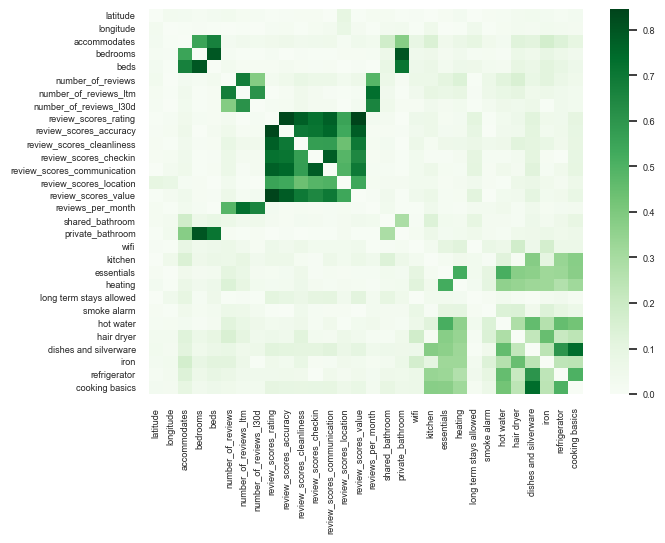

In [ ]:
sns.set(font_scale=0.6, rc={'figure.figsize':(7, 5)})
sns.heatmap(corr_matrix.iloc[0:30][corr_matrix.columns[0:30]], cmap='Greens')
plt.show()

We can observe from the heat map and correlation computations that all review are highly correlated and the number of reviews. We will create:
- A new column feature with the average of all the reviews and drop the previous review columns.
- A new keep only the column last three months review, accounts for the review for each quarter.

In [ ]:
scores = [c for c in df_paris.columns if 'review_scores' in c]
drop_reviews = [c for c in df_paris.columns if 'of_review' in c and 'ltm' not in c]

# create a new column with the mean of the reviews
df_paris['review_scores'] = df_paris[scores].mean(axis=1)

# drop colums
scores.extend(drop_reviews)
drop_columns(scores, df_paris)

In [ ]:
df_paris.shape

(88232, 163)

### 7.2  Partitioning dataset and encoding categorical features

In [ ]:
for c in df_paris[df_paris.columns[df_paris.dtypes == 'object']].columns:
    print(c, f'- unique categories: {len(df_paris[c].unique())}')

scrape_id - unique categories: 3
host_is_superhost - unique categories: 2
host_identity_verified - unique categories: 2
neighbourhood_cleansed - unique categories: 20
property_type - unique categories: 19
room_type - unique categories: 4
minimum_nights - unique categories: 3
maximum_nights - unique categories: 3
has_availability - unique categories: 2
instant_bookable - unique categories: 2


In [ ]:
seed = 123

y = df_paris.pop('price').astype('float32')
X = df_paris

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30,
                                                  stratify=X['neighbourhood_cleansed'],
                                                  random_state=seed)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.6,
                                                random_state=seed)


In [ ]:
categorical_feat = X_train.select_dtypes(include=['O']).columns
num_feat = X_train.select_dtypes(exclude=['O']).columns
print(f'Categorical features: {len(categorical_feat)}')
print('-------------' * 2)
print(f'Numerical features: {len(num_feat)}')
print('-------------' * 2)

Categorical features: 10
--------------------------
Numerical features: 152
--------------------------


### 7.3 Build feature selection pipeline

In [ ]:
# Feature transformer
encode = make_column_transformer((OneHotEncoder(drop='if_binary',
                   handle_unknown='infrequent_if_exist'), categorical_feat), remainder='passthrough')
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

#### 7.3.3 SelectPercentile with mutual_info_regression

In [ ]:
# Build scaler and feature selection pipeline
pre_processing = make_pipeline(encode, scaler,
                               SelectPercentile(mutual_info_regression, percentile=50))

In [ ]:
# Transform and scale train split
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
x_train_transformed = pre_processing.fit_transform(X_train, y_train_scaled.ravel())

In [ ]:
x_val_transformed = pre_processing.transform(X_val)
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1))

In [ ]:
score_ind = np.where(pre_processing[-1].get_support()==True)[0]
features = pre_processing.get_feature_names_out()

In [ ]:
short_feat = [f.split('__')[1] for f in features]

In [ ]:
dic={'feature':short_feat,
                         'score':pre_processing[-1].scores_[score_ind]}
best_feat = pd.DataFrame(dic).sort_values(by="score", ascending=False)

In [ ]:
sns.set_style(style='white')

In [ ]:
print(x_train_transformed.shape[1])

104


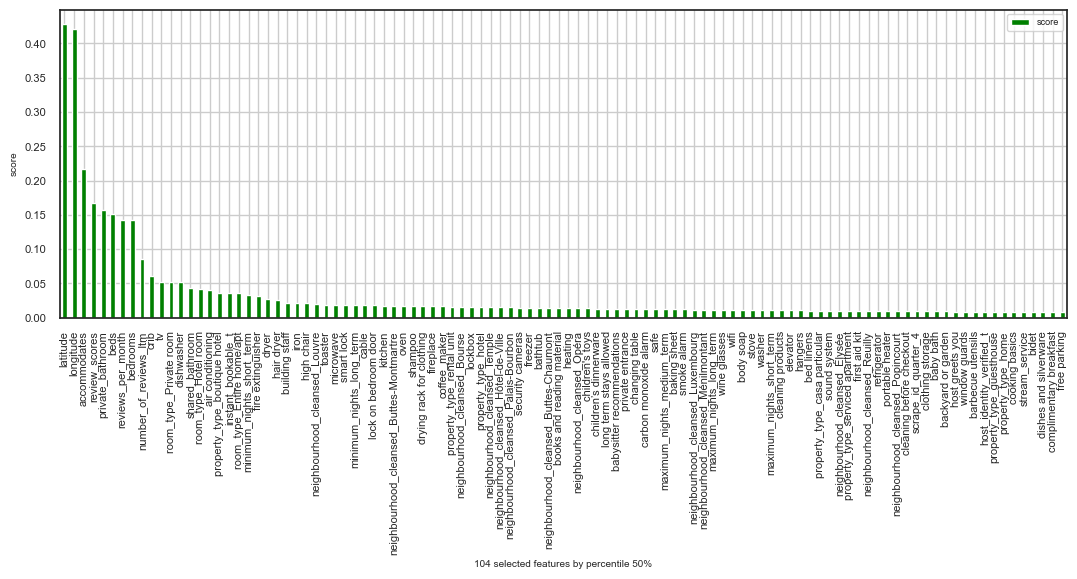

In [ ]:
best_feat.plot.bar(x='feature', y='score', figsize=(13,4), fontsize=8, color='green')
plt.xlabel(f'{x_train_transformed.shape[1]} selected features by percentile 50%')
plt.ylabel('score')
plt.grid(visible=True, which='major')
plt.show()


---

 **3 most important features** - SelectPercentile with mutual_information_regression

1.   latitude
2.   longitude
3.   accommodates

---




In [ ]:
# Create a dataframe of the  transformed train split
short_feat.append('price')
profile_train = np.concatenate([x_train_transformed, y_train_scaled], axis=1)
profile_df = pd.DataFrame(profile_train, columns=short_feat)

In [ ]:
# Uncomment below to create a report with the scaled and selected training features
# from ydata_profiling import ProfileReport
# ProfileReport(profile_df)

## 8. Build the training, validation and test pipeline

In [ ]:
import torch.nn.functional as F
torch.manual_seed(123)
torch.cuda.manual_seed(123)

### 8.1 Build the models

#### __Build artificial neural network regressor__

In [ ]:
class PriceRegressor(nn.Module):
    def __init__(self, inputs=None, hidden=None, p=0.2):

        super(PriceRegressor, self).__init__()

        assert len(hidden) == 3, 'hidden must be a list containing three sizes'

        self.input = inputs
        self.hidden = hidden
        self.dropout = nn.Dropout(p)

        self.regressor = nn.Sequential(
            nn.Linear(self.input, self.hidden[0]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(self.hidden[0], self.hidden[1]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(self.hidden[1], self.hidden[2]),
            nn.ReLU(),
            nn.Linear(self.hidden[2], 1))

    def forward(self, x):

        x = x.type('torch.FloatTensor').to(device)

        out = self.regressor(x)

        return out.view(-1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_models(num_features=None):
    common_params = dict(random_state=123, learning_rate=0.05, max_depth=10)
    models = dict()

    # Linear Models
    models['linear_regression'] = LinearRegression(n_jobs=8)
    models['ridge'] = Ridge(random_state=123)
    models['bayesian_ridge'] = BayesianRidge()

    # Support Vector Machines
    models['svr'] = SVR(C=10, cache_size=500)

    # Decision trees
    models['decision_tree'] = DecisionTreeRegressor(max_depth=10, random_state=123,
                                                    )
    # Ensemble methods
    models['random_forest'] = RandomForestRegressor(random_state=123, n_estimators=500,
                                                     max_depth=10, min_samples_leaf=20, n_jobs=8)
    models['gradient_boosting'] = GradientBoostingRegressor(**common_params, n_estimators=500,
                                                            min_samples_leaf=20)
    models['hist_gradient_boosting'] = HistGradientBoostingRegressor(**common_params,
                                                                     l2_regularization=0.001,
                                                                     min_samples_leaf=20)

    models['xgb'] = XGBRegressor(learning_rate=0.05, booster='gbtree', tree_method='exact',
                                 max_leaves=2, max_depth=10, n_estimators=500,
                                 alpha=0.001, random_state=123, device='cpu', verbosity=0)

    models['LGBM'] = LGBMRegressor(**common_params, n_estimators=500, alpha=0.001,
                                   num_leaves=30, force_row_wise=True)

    # Shallow neural network
    models['ann_regressor'] = NeuralNetRegressor(module=PriceRegressor,
                                                 module__inputs=num_features,
                                                 module__hidden=[512, 512, 256],
                                                 module__p=0.3,
                                                 train_split=None,
                                                 max_epochs=120,
                                                 optimizer=torch.optim.AdamW,
                                                 lr=0.001,
                                                 device=device,
                                                 iterator_train__shuffle=True,
                                                 verbose=0)

    return models

#### 8.5 Helper function, training and evaluation functions

In [ ]:
def evaluation(x, y, model, full_pipeline=False):

    if full_pipeline:
        y_pred = model.predict(x)

    else:
        y = target_scaler.inverse_transform(y.reshape(-1, 1))
        y_pred = model.predict(x)
        y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))

    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)

    return r2, mae, mape, mse, rmse, y_pred

In [ ]:
def train_models(train, val, model_dir=None, save=True):

    metrics = defaultdict(dict)
    predictions = {}
    x_train, y_train = train[0], train[1]
    x_val, y_val = val[0], val[1]

    models = get_models(x_train.shape[1])

    for k, v in tqdm(models.items()):
        print('')
        print(f'Building {k} pipeline')

        model = v.fit(x_train, y_train.ravel())
        r2 = round(model.score(x_train, y_train), 4)

        # Validation
        v_r2, v_mae, v_mape, v_mse, v_rmse, v_pred = evaluation(x_val, y_val, model)

        print('r2 training score: {0:.4f} | validation score: {1:.4f} '.format(
                                                                    r2, v_r2))
        if save:
            filename = os.path.join(model_dir, f'{k}.jbl')
            joblib.dump(model, filename)

        metrics[k] = {'train_r2': r2, 'val_r2': v_r2, 'mean_yhat_val': v_pred.mean(),
                      'val_mae': v_mae, 'val_mape': v_mape, 'val_mse': v_mse, 'val_rmse': v_rmse}

        predictions[k] = v_pred

    return metrics, predictions

## 9. Train, validation, test and evaluation of the models performance

### 9.1 Train, validation, test and evaluation

In [ ]:
models_dir = os.path.join(os.getcwd(), 'weights')
try:
    os.makedirs(models_dir, exist_ok=False)
except FileExistsError:
    pass

In [ ]:
all_metrics, val_predictions = train_models((x_train_transformed, y_train_scaled),
                                (x_val_transformed, y_val_scaled),
                                  models_dir)

  9%|████▎                                          | 1/11 [00:00<00:01,  9.93it/s]


Building linear_regression pipeline
r2 training score: 0.5512 | validation score: 0.5513 

Building ridge pipeline
r2 training score: 0.5509 | validation score: 0.5518 

Building bayesian_ridge pipeline


 27%|████████████▊                                  | 3/11 [00:00<00:02,  2.96it/s]

r2 training score: 0.5512 | validation score: 0.5516 

Building svr pipeline


 36%|█████████████████                              | 4/11 [00:46<01:52, 16.13s/it]

r2 training score: 0.7590 | validation score: 0.6383 

Building decision_tree pipeline


 45%|█████████████████████▎                         | 5/11 [00:47<01:06, 11.04s/it]

r2 training score: 0.6381 | validation score: 0.5944 

Building random_forest pipeline
r2 training score: 0.6606 | validation score: 0.6394 


 55%|█████████████████████████▋                     | 6/11 [01:14<01:19, 15.98s/it]


Building gradient_boosting pipeline


 64%|█████████████████████████████▉                 | 7/11 [05:45<06:24, 96.21s/it]

r2 training score: 0.9044 | validation score: 0.7936 

Building hist_gradient_boosting pipeline


 73%|██████████████████████████████████▏            | 8/11 [05:47<03:20, 66.94s/it]

r2 training score: 0.7008 | validation score: 0.6877 

Building xgb pipeline


 82%|██████████████████████████████████████▍        | 9/11 [07:08<02:22, 71.30s/it]

r2 training score: 0.9459 | validation score: 0.8039 

Building LGBM pipeline
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 61762, number of used features: 104
[LightGBM] [Info] Start training from score 0.140500


 91%|█████████████████████████████████████████▊    | 10/11 [07:10<00:50, 50.33s/it]

r2 training score: 0.7886 | validation score: 0.7420 

Building ann_regressor pipeline
r2 training score: 0.9014 | validation score: 0.7609 


100%|██████████████████████████████████████████████| 11/11 [14:46<00:00, 80.55s/it]


In [ ]:
metrics_robust_scaler = pd.DataFrame.from_dict(all_metrics).round(4)
metrics_robust_scaler.to_csv('metrics_robust_scaled.csv')
metrics_robust_scaler.to_markdown('metrics_robust.md')

In [ ]:
metrics_robust_scaler = pd.read_csv('metrics_robust_scaled.csv', index_col=[0])

In [ ]:
metrics_robust_scaler

,linear_regression,ridge,bayesian_ridge,svr,decision_tree,random_forest,gradient_boosting,hist_gradient_boosting,xgb,LGBM,ann_regressor
train_r2,0.5512,0.5509,0.5512,0.7590,0.6381,0.6606,0.9044,0.7008,0.9459,0.7886,0.9014
val_r2,0.5513,0.5518,0.5516,0.6383,0.5944,0.6394,0.7936,0.6877,0.8039,0.7420,0.7609
mean_yhat_val,155.4762,155.4898,155.4817,166.9753,155.0423,155.0555,155.2303,155.3484,155.3208,155.1306,152.9984
val_mae,50.3986,50.4400,50.4109,50.4770,47.0199,44.5361,33.0069,41.4407,31.6224,37.6685,35.6999
val_mape,0.3819,0.3820,0.3819,0.4307,0.3437,0.3301,0.2412,0.3072,0.2308,0.2757,0.2795
val_mse,5426.5715,5420.4795,5422.5558,4374.1229,4905.6751,4360.7846,2495.4936,3777.3285,2371.0896,3119.5080,2891.4407
val_rmse,73.6653,73.6239,73.6380,66.1372,70.0405,66.0362,49.9549,61.4600,48.6938,55.8526,53.7721


In [ ]:
import scipy.stats as ss

In [ ]:
# Find statistical comparison among the three top models
H, p_value = ss.kruskal(val_predictions['xgb'], val_predictions['ann_regressor'],
                            val_predictions['gradient_boosting'])
f'Reject the null hypothesis p-value: {p_value[0]:.4f}' if p_value <= 0.05 else f'Fail to reject the null hypothesis p-value: {p_value[0]:.4f}'

'Reject the null hypothesis p-value: 0.0010'

In [ ]:
stat, p =  ss.ks_2samp(val_predictions['xgb'].reshape(-1), val_predictions['ann_regressor'].reshape(-1), alternative='two-sided', method='auto')
print('Statistical Comparison vs and ann_regressor: Two-sample Kolmogorov–Smirnov test')
f'Reject the null hypothesis: {p:.4f}' if p <= 0.05 else f'Fail to reject the null hypothesis p-value: {p:.4f}'

Statistical Comparison vs and ann_regressor: Two-sample Kolmogorov–Smirnov test


'Reject the null hypothesis: 0.0000'

In [ ]:
stat_2, p2 =ss.ks_2samp(val_predictions['xgb'].reshape(-1), val_predictions['gradient_boosting'].reshape(-1), alternative='two-sided', method='auto')
print('Statistical Comparison xgb vs gradient_boosting: Two-sample Kolmogorov–Smirnov test')
f'Reject the null hypothesis  {p2:.4f}' if p2 <= 0.05 else f'Fail to reject the null hypothesis p-value: {p2:.4f}'

Statistical Comparison xgb vs gradient_boosting: Two-sample Kolmogorov–Smirnov test


'Fail to reject the null hypothesis p-value: 0.9915'

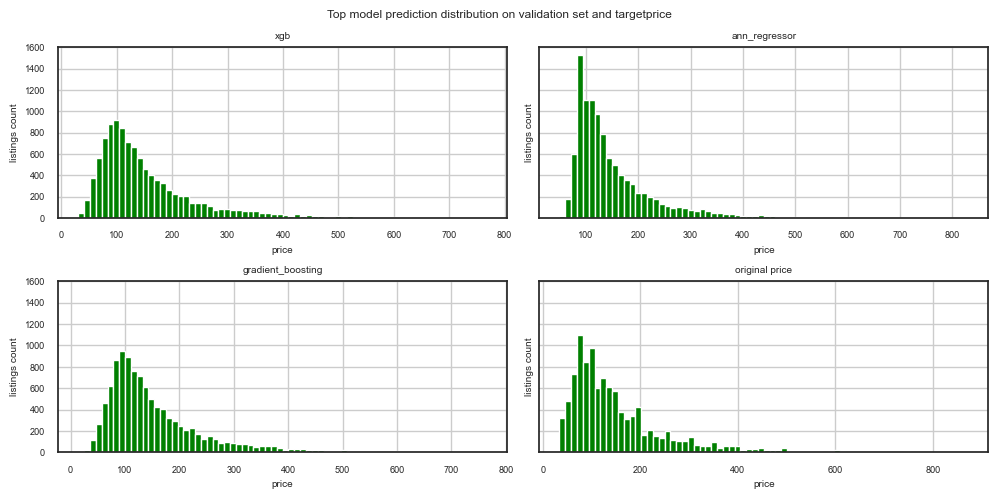

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Top model prediction distribution on validation set and targetprice')
axs[0, 0].hist(val_predictions['xgb'], bins=70, color='Green')
axs[0, 0].set_title('xgb')
axs[0, 1].hist(val_predictions['ann_regressor'], bins=70, color='Green')
axs[0, 1].set_title('ann_regressor')
axs[1, 0].hist(val_predictions['gradient_boosting'], bins=70, color='Green')
axs[1, 0].set_title('gradient_boosting')
axs[1, 1].hist(y_val.values, bins=70 , color='Green')
axs[1, 1].set_title('original price')

for ax in axs.flat:
    ax.set(xlabel='price', ylabel='listings count')
    ax.grid()
plt.tight_layout()
plt.show()

### 9.2 Ranking Models

In [ ]:
models_rank = metrics_robust_scaler.copy().T

for col in models_rank:
    if 'mean' in col:
        pass
    else:
        if 'r2' in col:
            models_rank[f'rank_{col}'] = models_rank[col].rank(ascending=False)

        else: models_rank[f'rank_{col}'] = models_rank[col].rank()
        drop_columns(col, models_rank)
models_rank.to_markdown('models_ranks_robust.md')

In [ ]:
models_rank

,mean_yhat_val,rank_train_r2,rank_val_r2,rank_val_mae,rank_val_mape,rank_val_mse,rank_val_rmse
linear_regression,155.4762,9.5,11.0,8.0,8.5,11.0,11.0
ridge,155.4898,11.0,9.0,10.0,10.0,9.0,9.0
bayesian_ridge,155.4817,9.5,10.0,9.0,8.5,10.0,10.0
svr,166.9753,5.0,7.0,11.0,11.0,7.0,7.0
decision_tree,155.0423,8.0,8.0,7.0,7.0,8.0,8.0
random_forest,155.0555,7.0,6.0,6.0,6.0,6.0,6.0
gradient_boosting,155.2303,2.0,2.0,2.0,2.0,2.0,2.0
hist_gradient_boosting,155.3484,6.0,5.0,5.0,5.0,5.0,5.0
xgb,155.3208,1.0,1.0,1.0,1.0,1.0,1.0
LGBM,155.1306,4.0,4.0,4.0,3.0,4.0,4.0


---

Statistical Summary

---

From the statistical testing, we can conclude  that:

- Gradient Boosting and XGBoost models predict price with no statistical significance with 95\% confidence
- The performance of XGBoost is statistically different from the shallow artificial neural network with 95\% confidence
- The model with the highest rank in all metrics is XGBoost, and trains faster than Gradient Boosting. Therefore, this model will be optimised.

## 10. Hyper parameter tuning for the best ranked model

### 10.1 Gridsearch for XGBoost

In [ ]:
# Concatenate train and val splits
X_grid = pd.concat([X_train, X_val])
y_grid = pd.concat([y_train, y_val])

In [ ]:
best_model = [model for model in models_rank.rank_val_rmse.nsmallest(n=1).keys()][0]
print(f'Best model: {best_model.upper()}')
essemble_model = {k: v for (k, v) in get_models(X_train.shape[1]).items() if k == best_model}

Best model: XGB


In [ ]:
xgb_processing = make_pipeline(encode, )

In [ ]:
# Run set verbosity to one to silence warning
essemble_model['xgb'].set_params(verbosity=1)

XGBRegressor(alpha=0.001, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=2,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# !python -m pip install skops

In [ ]:
def grid_search(model=None, preprocessing=None, x=None, y=None, model_dir=models_dir):

    assert type(model) == dict, 'models must be a dictionary'


    for k, v in tqdm(model.items()):

        print(f'Optimizing {k}')

        pipeline = make_pipeline(preprocessing, v)

        model = TransformedTargetRegressor(regressor=pipeline,
                                            transformer=target_scaler)

        name = list(pipeline.get_params().keys())[4]

        params_grid = {f'regressor__{name}__max_depth': [8, 10],
            f'regressor__{name}__n_estimators': [500, 800, 1000],
            f'regressor__{name}__learning_rate': [0.3, 0.1, 0.05]}

        grid_search = GridSearchCV(model, params_grid, scoring='neg_root_mean_squared_error',
                                         verbose=1, n_jobs=1)

        output = grid_search.fit(x, y)

        best_model = output.best_estimator_

        print(f'Best Score: {abs(grid_search.best_score_)}')
        print(f'Best Hyperparameters: {grid_search.best_params_}')

        filename = os.path.join(model_dir, f'best_{k}_model.jbl')

        joblib.dump(best_model, filename)

        return output

In [ ]:
search = grid_search(essemble_model, pre_processing, X_grid, y_grid)

  0%|                                                        | 0/1 [00:00<?, ?it/s]

Optimizing xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score: 47.42583465576172
Best Hyperparameters: {'regressor__xgbregressor__learning_rate': 0.1, 'regressor__xgbregressor__max_depth': 10, 'regressor__xgbregressor__n_estimators': 1000}


  0%|                                                      | 0/1 [4:21:19<?, ?it/s]


---
__Best score__

---

- RMSE: 46.3

---

__Best paramaters__

---
- learning_rate: 0.1
- max_depth': 10
- n_estimators': 1000

### 10.2 Evaluate the optimized model on unseen data

In [ ]:
# Load the best estoimator
xgb_regressor = joblib.load(os.path.join(os.getcwd(), 'weights', 'best_xgb_model.jbl'))

In [ ]:
r2, mae, mape, mse, rmse, y_pred = evaluation(X_test, y_test, xgb_regressor, full_pipeline=True)

In [ ]:
print('Mean price: {0:.2f}'.format(np.round(y_pred.mean(), 2)))
print('Coefficient of determination: {0:.2f}'.format(r2))
print('Mean absolute error: {0:.2f}'.format(mae))
print('Mean absolute percent error: {0:.2f}'.format(mape))
print('Mean square error: {0:.2f}'.format(mse))
print('Mean root square error: {0:.2f}'.format(rmse))

Mean price: 156.43
Coefficient of determination: 0.83
Mean absolute error: 28.27
Mean absolute percent error: 0.20
Mean square error: 2005.96
Mean root square error: 44.79


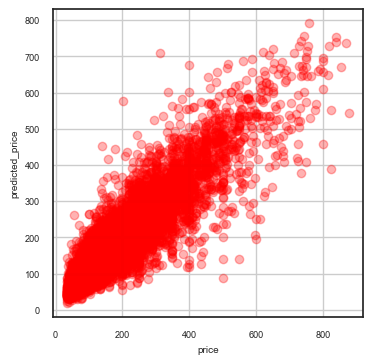

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred, color='red', alpha=0.3)
plt.xlabel('price')
plt.ylabel('predicted_price')
plt.grid(visible=True)
plt.show()

### 10.3 Get the feature importance

In [ ]:
# Get the features importance from the best
transformed_features = xgb_regressor.regressor_[:-1].get_feature_names_out()
features_names = np.array([f.split('__')[1] for f in transformed_features])
# selected_ind = np.where(xgb_regressor.regressor_.named_steps.selectpercentile.get_support() ==True)[0]
# selected_features= features_names[selected_ind]

In [ ]:
importances = xgb_regressor.regressor_['xgbregressor'].feature_importances_
xgb_importances = pd.Series(importances, index=features_names).sort_values(ascending=False)

In [ ]:
len(xgb_regressor.regressor_['xgbregressor'].feature_importances_)

104

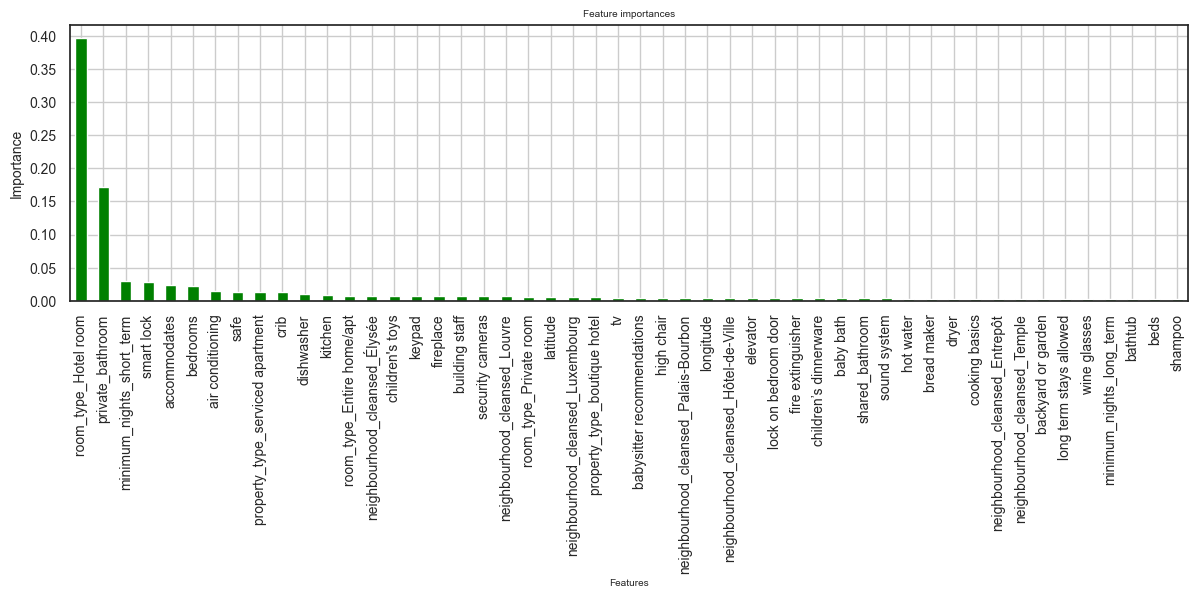

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
xgb_importances[:50].plot.bar(ax=ax, color='Green', fontsize=10)
ax.set_title("Feature importances")
ax.set_ylabel("Importance", fontsize=10)
ax.set_xlabel("Features")
ax.grid()
fig.tight_layout()
plt.show()
save_plot('feature_importances', x='Features', y='Importances')

---
10 Most important features

---
- room_type_Hotel room,
- private_bathroom
- minimum_nights_short_term
- smart lock
- accommodates
- bedrooms
- air conditioning
- safe
- property_type_serviced apartment
- crib



In [ ]:
grid_results = pd.DataFrame(search.cv_results_)
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__xgbregressor__learning_rate,param_regressor__xgbregressor__max_depth,param_regressor__xgbregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,141.504919,18.657192,0.353988,0.049528,0.3,8,500,{'regressor__xgbregressor__learning_rate': 0.3...,-49.368996,-50.589729,-48.977886,-50.079086,-49.617741,-49.726688,0.560275,12
1,174.756975,3.296451,0.289022,0.008294,0.3,8,800,{'regressor__xgbregressor__learning_rate': 0.3...,-48.741707,-50.892719,-49.307575,-49.068409,-49.363155,-49.474713,0.742092,9
2,194.865017,9.034986,0.304745,0.025415,0.3,8,1000,{'regressor__xgbregressor__learning_rate': 0.3...,-48.775345,-50.624870,-48.872444,-48.500397,-48.466953,-49.048002,0.803637,7
3,169.917869,7.666959,0.307560,0.020909,0.3,10,500,{'regressor__xgbregressor__learning_rate': 0.3...,-48.942528,-50.470940,-49.934052,-48.919289,-49.766014,-49.606564,0.598850,11
4,170.682199,14.197776,0.286692,0.025026,0.3,10,800,{'regressor__xgbregressor__learning_rate': 0.3...,-49.186962,-50.960022,-49.267750,-49.888893,-49.724575,-49.805640,0.635325,13


# 11. Explainability - XAI

In [ ]:
import time
import copy
from tqdm import tqdm
from types import SimpleNamespace
import xgboost
from fasttreeshap import TreeExplainer, plots, initjs, summary_plot, force_plot, utils
import time
import copy


In [ ]:
 # Set verbosity to 0 for the newest xgboost version warning
xgboost.set_config(verbosity=0)

## 11.1 Prepare the data

We compute the shap number for each of the features with and without scaled values.

As per [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Explaining%20a%20model%20that%20uses%20standardized%20features.html) "When explaining a model that uses standardized features it is often desirable to get explanations using the original input features (not their standardized versions)".

In [ ]:
xgb_regressor.regressor_[0]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  Index(['scrape_id', 'host_is_superhost', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'instant_bookable'],
      dtype='object'))])),
                ('minmaxscaler', MinMaxScaler()),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7ff1565df8b0>))])

In [ ]:
#########   All transformations ############
y_test_trans = xgb_regressor.transformer_.transform(y_test.values.reshape(-1,1))
x_test_trans = xgb_regressor.regressor_[0].transform(X_test)
x_test_df = pd.DataFrame(x_test_trans, columns=features_names)

### 11.2 Shapley values

In [ ]:
from fasttreeshap import dependence_plot, decision_plot, plots
from types import SimpleNamespace

In [ ]:
# Create explainer and
explainer = TreeExplainer(xgb_regressor.regressor_[-1], n_jobs=8)
shap_values = explainer(x_test_df)

In [ ]:
ind = np.where(xgb_regressor.regressor_[0][-1].get_support() == True)[0]
rescaled_data = xgb_regressor.regressor_[0][1:].inverse_transform(shap_values.data)[:, ind]

In [ ]:
# Compute values proportions
shap_values_proportions = shap_values.values/shap_values.values.sum(axis=1).reshape(-1,1)

rescaled_base_value = xgb_regressor.transformer_.inverse_transform(shap_values.base_values)

rescaled_total_value = xgb_regressor.transformer_.inverse_transform(shap_values.base_values + shap_values.values.sum(axis=1).reshape(-1,1))

shap_rescaled_values = shap_values_proportions * (rescaled_total_value - rescaled_base_value)

In [ ]:
shap_values.values = shap_rescaled_values
shap_values.base_values = rescaled_base_value
shap_values.data = rescaled_data

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


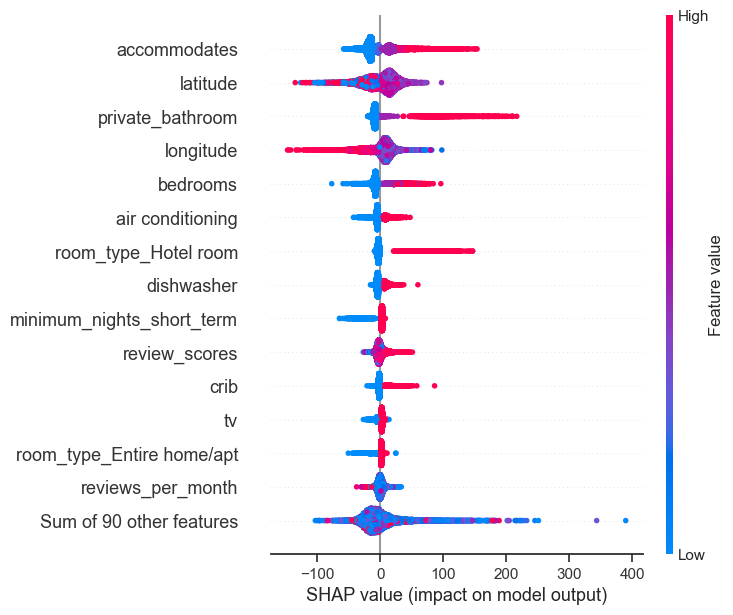

In [ ]:
# summarize the effects of all the features
plots.beeswarm(shap_values, max_display=15, plot_size=[6,7])

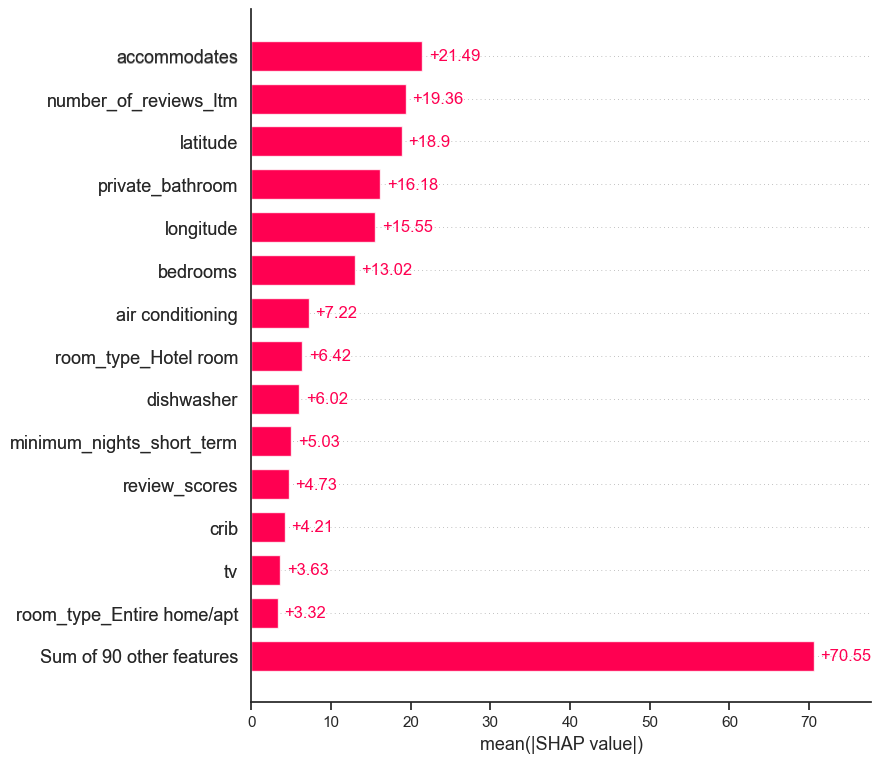

In [ ]:
plots.bar(shap_values, max_display=15)

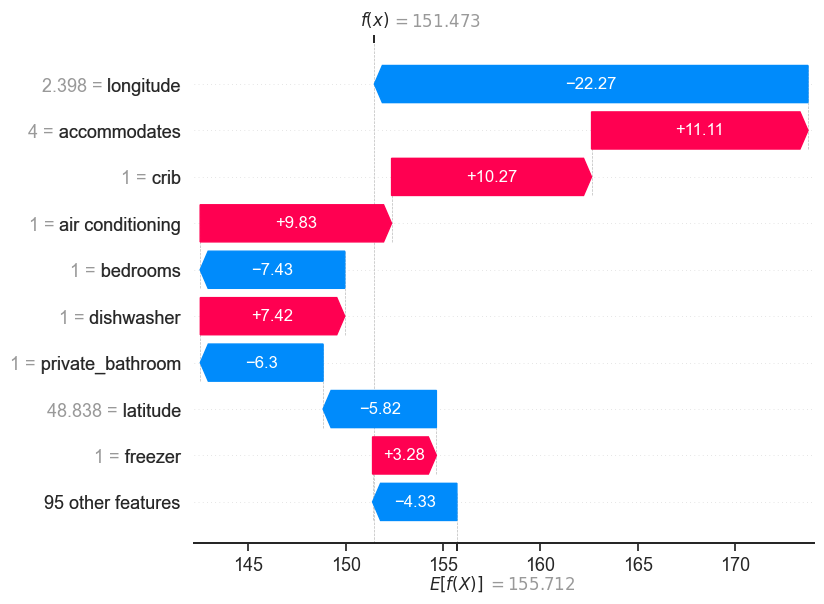

In [ ]:
to_pass = SimpleNamespace(**{'values':shap_values.values[876],
                          'data': shap_values.data[876],
                          'feature_names': x_test_df.columns,
                        'base_values': shap_values.base_values[876][0]})
plots.waterfall(to_pass, max_display=10)

In [ ]:
initjs()
force_plot(shap_values[876],  figsize=15)

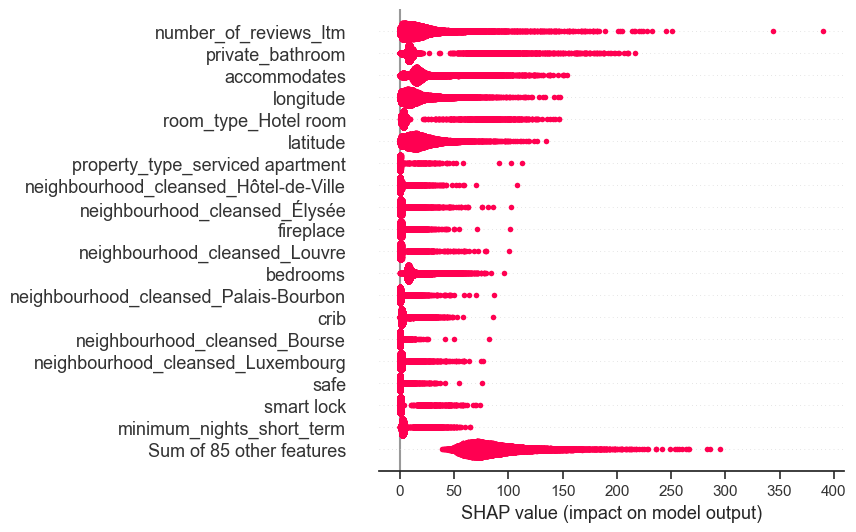

In [ ]:
plots.beeswarm(shap_values.abs, order=shap_values.abs.max(0), color="shap_red", max_display=20,
                           plot_size=[6,6])

In [ ]:
rng = np.random.default_rng(123)
idx = rng.integers(low=0, high=len(X_test), size=600)
initjs()
plots.force(shap_values.base_values[0], shap_values.values[idx[0:300]], feature_names=x_test_df.columns)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
105it [01:31,  1.01it/s]                                                           


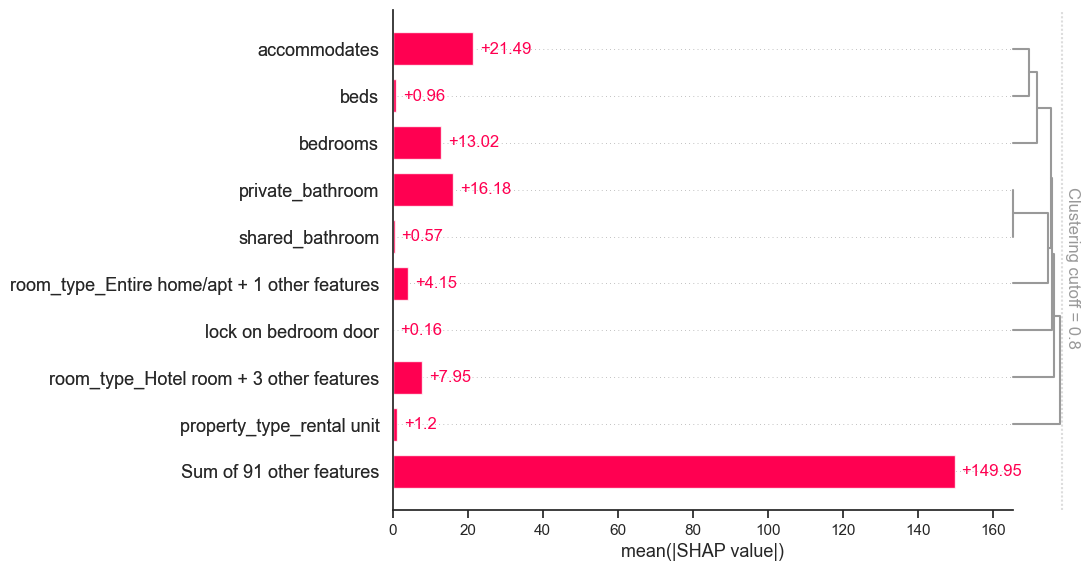

In [ ]:
clustering = utils.hclust(rescaled_data, y_test)
plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8, max_display=10)

### Largest contributors to the price (mean values contribution):

- **accommodates**
- **num_of_reviews**
- **latitude**
- **private bathroom**
- **longitude**

---


### Largest contributors to the price absolute value:

- **num_of_reviews_ltm**
- **private bathroom**
- **accommodates**
- **longitude**
- **room_type_Hotel room**
